In [1]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Global seed set to 0


In [38]:
tox_adata = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox1-full/single_cell_objects/filtered_pflog1ppfnorm.hvg.umap_embedding.h5ad")
tox_adata_raw = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox1-full/single_cell_objects/filtered.h5ad")

In [39]:
assert tox_adata.obs.index.equals(tox_adata_raw.obs.index)

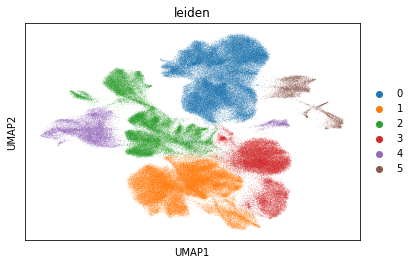

In [40]:
sc.pl.umap(tox_adata, color='leiden')

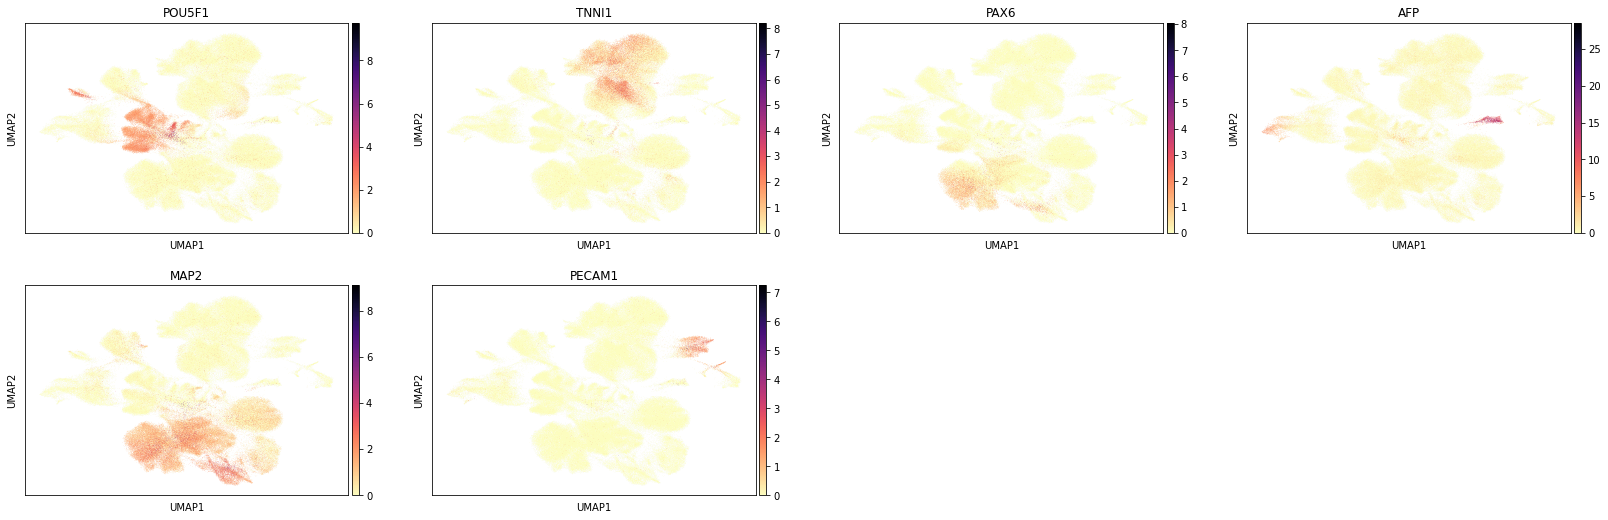

In [41]:
sc.pl.umap(tox_adata, color=['POU5F1', 'TNNI1', 'PAX6', 'AFP', 'MAP2', 'PECAM1'], color_map='magma_r')

In [42]:
celltype_labels = {0: 'mesoderm', 1:'earlyecto', 2: 'pluripotent', 3: 'neuron', 4: 'endoderm', 5: 'endothelial'}

In [43]:
tox_adata.obs['celltype'] = [celltype_labels[int(c)] for c in tox_adata.obs['leiden']]

In [44]:
treatment_map = {
    '01': 'DMSO',
    '02': 'DMSO',
    '03': 'Difloxacin',
    '04': 'Difloxacin',
    '05': 'Ambrisentan',
    '06': 'Ambrisentan',
    '07': 'BIA',
    '08': 'BIA',
    '09': 'Fialuridine',
    '10': 'Fialuridine',
    '11': 'Benfluorex_DMSO',
    '12': 'Benfluorex_DMSO',
    '13': 'Benfluorex_H2O',
    '14': 'Benfluorex_H2O',
    '15': 'Pergolide',
    '16': 'Pergolide'
}

In [47]:
tox_adata.obs['treatment_name'] = [treatment_map[t] for t in tox_adata.obs['treatment']]

In [45]:
cell_subset = tox_adata.obs[['sample_id', 'donor_id', 'celltype']]
cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)

/tmp/jobs/31452801/ipykernel_134739/782936707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)


In [46]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['pseudobulk_sample']])
onehot

<241816x450 sparse matrix of type '<class 'numpy.float64'>'
	with 241816 stored elements in Compressed Sparse Row format>

In [14]:
pseudobulk_sum = tox_adata_raw.X.transpose() * onehot

In [15]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum.todense(),
                              index=tox_adata_raw.var_names, 
                              columns=cell_subset['pseudobulk_sample'].astype("category").cat.categories).astype(int)

In [18]:
pseudobulk_sum.to_csv("/project/gilad/jpopp/cellcipher/data/Tox1-full/pseudobulk_expression.tsv", sep="\t")

In [48]:
treatment_dict = tox_adata.obs[['sample_id', 'treatment', 'treatment_name']].drop_duplicates()

In [49]:
treatment_dict

,sample_id,treatment,treatment_name
cell,,,
AAACCCAAGATAGTCA-1,YG-KR-10X-13s-Tox-04,04,Difloxacin
AAACCCAAGAATTGTG-2,YG-KR-10X-13s-Tox-03,03,Difloxacin
AAACCCAAGACCATTC-3,YG-KR-10X-13s-Tox-02,02,DMSO
AAACCCAAGACGACGT-4,YG-KR-10X-13s-Tox-05,05,Ambrisentan
AAACCCAAGACAGTCG-5,YG-KR-10X-13s-Tox-09,09,Fialuridine
AAACCCAAGAAACTGT-6,YG-KR-10X-13s-Tox-10,10,Fialuridine
AAACCCAAGCTGTACT-7,YG-KR-10X-13s-Tox-01,01,DMSO
AAACCCACAATACGAA-8,YG-KR-10X-13s-Tox-08,08,BIA
AAACCCAAGATAGTCA-9,YG-KR-10X-13s-Tox-13,13,Benfluorex_H2O


In [50]:
treatment_dict.to_csv("/project/gilad/jpopp/cellcipher/data/Tox1-full/treatment_dict.tsv", sep="\t", index=False)